In [5]:
# Load packages for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load packages for Big Query 
from google.cloud import bigquery
import os

### Set-up

**Set-up: GCP interface** 

Run before querying to setup Big Query

In [6]:
# Define configurations for Big Query - Stride Datalake
project_id = 'som-nero-phi-boussard' # Location of stride datalake
db = "som-nero-phi-boussard.stride_datalake" # Define the database
msc = "som-nero-phi-boussard.MSc_ACU_Oncology"
es = "som-nero-phi-boussard.ES_ACU_Oncology"
client = bigquery.Client(project=project_id) # Set project to project_id
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/eliasaquand/.config/gcloud/application_default_credentials.json'
os.environ['GCLOUD_PROJECT'] = "som-nero-phi-boussard" # specify environment
db = "som-nero-phi-boussard" # Define the database

/Users/eliasaquand/miniforge3/envs/env/lib/python3.9/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


**Set-up: GCP data table creation in Big Query**

In [7]:
# 1) Specify the job config to properly read the file
job_config = bigquery.LoadJobConfig()
job_config.autodetect = True # determines the datatype of the variable
job_config.write_disposition = 'WRITE_TRUNCATE'
job_config.max_bad_records = 1 # allow 5 bad records; 

# Read schema from JSON
# job_config.schema = self.bq_client.schema_from_json(
# f"{json_schema_dir}/{custom_mapping_table}.json")

# 2) Specify destination
# destination = f"som-nero-phi-boussard.MSc_ACU_Oncology.[COHORT NAME]"

# 3) Save file ob Big Query, using result from so far; client is specified above - implemented in the file 
# load_job = client.load_table_from_dataframe(dataframe = chemo_tx_dd,                                  
#                                                     destination = destination,
#                                                     job_config = job_config)

# Run the job:
# load_job.result()

### Select patients after OP-35 criteria
- cohort_p1: Max's cohort patient after OP-35 criteria
- cohort_p1_large: Max's cohort patient after OP-35 criteria + demographics information

These datasets are obtained after identifying the cancer patients that undergone chemotherapy and applying OP-35 inclusion and exclusion criteraataset. Both contains 16409 patients.

In [8]:
# Load cohort_p1 & remove INDEX_PRE_CHE col
sql_query = f""" SELECT * FROM {msc}.cohort_p1"""
cohort_p1 = (client.query(sql_query)).to_dataframe()
cohort_p1= cohort_p1.drop(columns=['INDEX_PRE_CHE'])

In [9]:
list(cohort_p1.columns)

['PAT_DEID', 'CHE_TX_DATE']

In [10]:
# Save cohort patient with OP-35 criteria
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.cohort_p1"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = cohort_p1,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=a0d82063-c49d-4212-8c6d-0aee1a633e59>

In [11]:
# Load cohort_p1_large & remove INDEX_PRE_CHE col
sql_query = f""" SELECT * FROM {msc}.cohort_p1_large"""
cohort_p1_large = (client.query(sql_query)).to_dataframe()
cohort_p1_large = cohort_p1_large.drop(columns=['INDEX_PRE_CHE'])

In [12]:
list(cohort_p1_large.columns)

['PAT_DEID',
 'CHE_TX_DATE',
 'BIRTH_DATE',
 'SEX',
 'ETHNIC_GROUP',
 'RACE',
 'HISPANIC',
 'TYPE_OF_DISEASE',
 'DX_DATE',
 'STAGE_FOUR',
 'AGE_AT_DX',
 'INSURANCE_PAYOR',
 'DEPRESSED',
 'CANCER_GROUP',
 'BIN_AGE']

In [13]:
# Save cohort patient with OP-35 criteria + demographic informations
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.cohort_p1_large"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = cohort_p1_large,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=9b0f0140-5ee1-44f3-aea4-739bfd6e1310>

### Augment and clean cohort_op35 table form Max 

- Add HOSP_DISCHRG_TIME column

In [14]:
db = "som-nero-phi-boussard.stride_datalake" # Define the database
db_max = "som-nero-phi-boussard.MSc_ACU_Oncology" # Define the database
sql_query = f"""
    SELECT DISTINCT cohort_op35.pat_deid, cohort_op35.dx_id, cohort_op35.dx_name, cohort_op35.icd9, cohort_op35.icd10, cohort_op35.primary, cohort_op35.chronic, cohort_op35.principal, cohort_op35.contact_date, cohort_op35.hosp_admsn_time, enc.hosp_dischrg_time, cohort_op35.pt_class, cohort_op35.pat_enc_csn_deid, cohort_op35.che_tx_date
    FROM {db_max}.cohort_op35 cohort_op35 
    LEFT JOIN {db}.shc_encounter enc ON cohort_op35.pat_deid = enc.pat_deid and cohort_op35.hosp_admsn_time = enc.hosp_admsn_time and cohort_op35.contact_date = enc.contact_date and cohort_op35.pt_class = enc.pt_class
"""
cohort_op35 = (client.query(sql_query)).to_dataframe()
cohort_op35.columns = [c.upper() for c in cohort_op35.columns]

In [15]:
cohort_op35.shape

(103620, 14)

In [16]:
cohort_op35.duplicated().sum()

0

In [17]:
cohort_op35.isna().sum()

PAT_DEID                  0
DX_ID                     0
DX_NAME                   0
ICD9                  68061
ICD10                  1997
PRIMARY               47198
CHRONIC               81721
PRINCIPAL            101037
CONTACT_DATE              0
HOSP_ADMSN_TIME          44
HOSP_DISCHRG_TIME        59
PT_CLASS                  0
PAT_ENC_CSN_DEID          0
CHE_TX_DATE               0
dtype: int64

In [18]:
# Save cohort patient with OP-35 criteria + demographic informations
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.cohort_op35_dschrg"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = cohort_op35,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=a275877c-52cd-4c74-8dd3-871dbff15a94>

- Add diagnosis source (check shc_diagnosis_source to get source description)

In [19]:
db = "som-nero-phi-boussard.stride_datalake" # Define the database
db_elia = "som-nero-phi-boussard.ES_ACU_Oncology" # Define the database
sql_query = f"""
    SELECT DISTINCT cohort_op35.pat_deid, cohort_op35.dx_id, cohort_op35.dx_name, cohort_op35.icd9, cohort_op35.icd10, cohort_op35.primary, cohort_op35.chronic, cohort_op35.principal, cohort_op35.contact_date, cohort_op35.hosp_admsn_time, cohort_op35.hosp_dischrg_time, cohort_op35.pt_class, cohort_op35.pat_enc_csn_deid, cohort_op35.che_tx_date, diag.source
    FROM {db_elia}.cohort_op35_dschrg cohort_op35 
    LEFT JOIN {db}.shc_diagnosis diag ON cohort_op35.pat_deid = diag.pat_deid and cohort_op35.dx_id = diag.dx_id and cohort_op35.dx_name = diag.dx_name and cohort_op35.primary = diag.primary and cohort_op35.chronic = diag.chronic and cohort_op35.principal = diag.principal
    """
df = (client.query(sql_query)).to_dataframe()
df.columns = [c.upper() for c in df.columns]

In [20]:
df.shape

(103620, 15)

In [21]:
df.isna().sum()

PAT_DEID                  0
DX_ID                     0
DX_NAME                   0
ICD9                  68061
ICD10                  1997
PRIMARY               47198
CHRONIC               81721
PRINCIPAL            101037
CONTACT_DATE              0
HOSP_ADMSN_TIME          44
HOSP_DISCHRG_TIME        59
PT_CLASS                  0
PAT_ENC_CSN_DEID          0
CHE_TX_DATE               0
SOURCE               103620
dtype: int64

In [22]:
df.duplicated().sum()

0

In [23]:
# Save cohort patient with OP-35 criteria + demographic informations
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.full_cohort_op35"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = df,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=30842bb8-7322-4351-8ca8-d31366ed4d53>

### Select patients with at least one ED visit or hospitalization within the 30 days follow-up

In [24]:
# Load clean cohort_op35 table 
sql_query = f""" SELECT * FROM {es}.full_cohort_op35"""
cohort_op35 = (client.query(sql_query)).to_dataframe()

In [25]:
print("No of unique patients in reference cohort, chemo patients): ", len(pd.unique(cohort_p1['PAT_DEID'])))
print("No of unique patients in op35 cohort (positive OP-35 criteria): ", len(pd.unique(cohort_op35['PAT_DEID'])))

No of unique patients in reference cohort, chemo patients):  16409
No of unique patients in op35 cohort (positive OP-35 criteria):  7484


In [26]:
cohort_op35.shape

(103620, 15)

In [27]:
cohort_op35.head()

,PAT_DEID,DX_ID,DX_NAME,ICD9,ICD10,PRIMARY,CHRONIC,PRINCIPAL,CONTACT_DATE,HOSP_ADMSN_TIME,HOSP_DISCHRG_TIME,PT_CLASS,PAT_ENC_CSN_DEID,CHE_TX_DATE,SOURCE
0,3145984,1024734,Other acute pain,338.19,R52,Y,None,None,2015-02-09,2015-02-09 18:46:00,2015-02-13 13:27:00,Inpatient,131071108332,2014-12-23,<NA>
1,3145984,8940,Pain in limb,729.5,M79.609,N,N,None,2015-02-09,2015-02-09 18:46:00,2015-02-13 13:27:00,Inpatient,131071108332,2014-12-23,<NA>
2,3145984,8940,Pain in limb,729.5,M79.609,None,None,None,2015-02-09,2015-02-09 18:46:00,2015-02-13 13:27:00,Inpatient,131071108332,2014-12-23,<NA>
3,3145984,8940,Pain in limb,729.5,M79.609,Y,None,None,2015-02-09,2015-02-09 18:46:00,2015-02-13 13:27:00,Inpatient,131071108332,2014-12-23,<NA>
4,3145984,1024732,Acute pain,338.19,R52,N,N,None,2015-02-09,2015-02-09 18:46:00,2015-02-13 13:27:00,Inpatient,131071108332,2014-12-23,<NA>


The OP-35 cohot is smaller because not everyone has an ACU event. 

- We continue working with all the patients from cohort_p1 that have an ACU = cohort_op35

In [28]:
# Calculate dates between contact and begin of chemotherapy = days until event happens
cohort_op35["CHE_TO_HOSP"] = (cohort_op35["HOSP_ADMSN_TIME"] - cohort_op35["CHE_TX_DATE"]).dt.days

In [29]:
op_df = cohort_op35.loc[(cohort_op35['CHE_TX_DATE']>='2013-01-01 00:00:00')]

In [30]:
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.op_df"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = op_df,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=6fd54ed0-5d40-4b2f-ac80-7e8ca8701e80>

In [31]:
# Select patients with CHE_TO_HOSP less or equal than 30 days
op_df_30 = op_df.loc[op_df['CHE_TO_HOSP']<=30]
op_df_30.shape

(11565, 16)

In [32]:
print("# of cancer patients with OP admit or ED w/in 1 mo: ", len(pd.unique(op_df_30['PAT_DEID'])))

# of cancer patients with OP admit or ED w/in 1 mo:  1848


<AxesSubplot: >

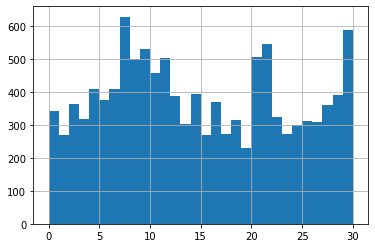

In [33]:
op_df_30['CHE_TO_HOSP'].hist(bins=30)

**Check the number of patients that have an ACU on chemotherapy day**

In [35]:
C = np.where(op_df_30.CHE_TO_HOSP == 0.0, True, False)

In [37]:
ids = pd.unique(op_df_30[C].PAT_DEID)

In [38]:
# Check the number of patients having an ACU on the chemotherapy day
len(ids)

97

In [41]:
only_chemo_ids = []
for pat_id in ids: 
    if op_df_30[op_df_30["PAT_DEID"] == pat_id].CHE_TO_HOSP.sum() == 0: 
        only_chemo_ids.append(pat_id)

In [42]:
# Check the number of patients having only one ACU on the chemotherapy day
len(only_chemo_ids)

57

In [45]:
df_only_chemo = op_df_30[op_df_30["PAT_DEID"].isin(only_chemo_ids)]

In [46]:
df_only_chemo.PT_CLASS.value_counts()

Inpatient             149
Emergency Services     52
Name: PT_CLASS, dtype: int64

- Look at patients that had an ED visit 

In [47]:
df_only_chemo_ed = df_only_chemo[df_only_chemo["PT_CLASS"] == 'Emergency Services']
only_chemo_ids_ed = pd.unique(df_only_chemo_ed.PAT_DEID)
len(only_chemo_ids_ed)

16

In [51]:
abs(df_only_chemo_ed.HOSP_ADMSN_TIME - df_only_chemo_ed.HOSP_DISCHRG_TIME).mean()

Timedelta('0 days 02:38:46.153846153')

- Look at patients that has been admitted to the hospital for hospitalization 

In [52]:
df_only_chemo_hosp = df_only_chemo[df_only_chemo["PT_CLASS"] == 'Inpatient']
only_chemo_ids_hosp = pd.unique(df_only_chemo_hosp.PAT_DEID)
len(only_chemo_ids_hosp)

41

In [53]:
abs(df_only_chemo_hosp.HOSP_ADMSN_TIME - df_only_chemo_hosp.HOSP_DISCHRG_TIME).max()

Timedelta('27 days 17:48:00')

- Remove the 16 patients that only had an ED visit on the chemotherapy day 

In [55]:
op_df_30 = op_df_30[~op_df_30.PAT_DEID.isin(only_chemo_ids_ed)]

In [58]:
print("# of cancer patients with OP admit or ED w/in 1 mo: ", len(pd.unique(op_df_30['PAT_DEID'])))

# of cancer patients with OP admit or ED w/in 1 mo:  1832


**Create cohort patient with at least one ED visit or hospitalization within the 30 days follow-up**

In [59]:
# We take the last HOSP_ADMSN_TIME for each patient 
cohort_p1_acu = pd.merge(op_df_30.sort_values(by=['PAT_DEID','HOSP_ADMSN_TIME']).drop_duplicates(subset='PAT_DEID', keep='last')[['PAT_DEID','HOSP_ADMSN_TIME']], cohort_p1, how="left",on = ['PAT_DEID']) 


In [60]:
cohort_p1_acu

,PAT_DEID,HOSP_ADMSN_TIME,CHE_TX_DATE
0,31,2014-02-24 15:04:00,2014-02-04 12:27:00
1,2374,2019-05-20 19:22:00,2019-05-20 00:00:00
2,4067,2019-03-22 23:26:00,2019-03-21 00:00:00
3,10540,2014-11-24 13:16:00,2014-11-19 00:00:00
4,10789,2018-02-14 14:47:00,2018-02-02 00:00:00
...,...,...,...
1827,4230712,2021-02-10 19:43:00,2021-01-25 00:00:00
1828,4244010,2021-06-22 12:26:00,2021-06-01 00:00:00
1829,4259783,2021-02-02 03:44:00,2021-01-22 00:00:00
1830,4316371,2021-02-23 16:07:00,2021-02-23 00:00:00


In [61]:
# Save cohort patient with at least one ED visit or hospitalization within the 30 days follow-up
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.cohort_p1_acu"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = cohort_p1_acu,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=2daa0539-e419-4bf2-8139-9fa732510afd>

In [62]:
# Check that we have only one entry for each patient 
cohort_p1_acu.groupby(['PAT_DEID'])['PAT_DEID'].value_counts().sum()

1832

### Select patients with at least one symptom in predefined symptom classes

Predefined symptom classes:
- Pain
- Nausea-Vomiting(Emesis)-Dehydration-Diarrhea
- Anemia
- Sepsis-Neutropenia-Fever-Pneuomia


In [63]:
sql_query = f""" SELECT * FROM {es}.cohort_p1_acu"""
cohort_p1_acu = (client.query(sql_query)).to_dataframe()

In [64]:
# Get all DX_NAME for all ACU event within 30 days 
cohort_p1_sym = pd.merge(cohort_p1_acu[["PAT_DEID"]], op_df_30, how="left", on=["PAT_DEID"])

In [65]:
# Check for duplicates rows  
cohort_p1_sym.duplicated().sum()

0

In [66]:
# Remove duplicate rows
cohort_p1_sym.drop_duplicates(inplace=True)
cohort_p1_sym.shape

(11513, 16)

In [67]:
anemia = cohort_p1_sym['DX_NAME'].str.upper().apply(lambda x: any(y in x for y in ["ANEM","RED CELL"]))
dehydration = cohort_p1_sym['DX_NAME'].str.upper().apply(lambda x: any(y in x for y in ["DEHY","HYPERNAT"]))
diarrhea = cohort_p1_sym['DX_NAME'].str.upper().apply(lambda x: x.find("DIAR")!=-1)
emesis = cohort_p1_sym['DX_NAME'].str.upper().apply(lambda x: any(y in x for y in ["EMES","VOMIT","GASTROENTER","GASTRIT"]))
fever =  cohort_p1_sym['DX_NAME'].str.upper().apply(lambda x: any(y in x for y in ["FEVER","FEBRILE","HYPERTHERM","PYREX"]))
nausea = cohort_p1_sym['DX_NAME'].str.upper().apply(lambda x: x.find("NAUS")!=-1)
neutropenia = cohort_p1_sym['DX_NAME'].str.upper().apply(lambda x: any(y in x for y in ["NEUT","PANCY","AGRAN"]))
pain = cohort_p1_sym['DX_NAME'].str.upper().apply(lambda x: any(y in x for y in ["PAIN","HEADACH","ALGIA","DYSURIA","DYNIA","ACHE","PRESSURE","DISCOMFORT","CRAMP", "TIGHTNESS","RADICULOPATHY","TENDERNES", "ABDOMINAL CRIS"]))
pneumonia = cohort_p1_sym['DX_NAME'].str.upper().apply(lambda x: any(y in x for y in ["PNEUMO","CONSOLID"]))
sepsis = cohort_p1_sym['DX_NAME'].str.upper().apply(lambda x: any(y in x for y in ["SEPS","INFLAM","CANDIDEMIA","SEPTIC"]))

# Shorten diagnosis names and call it dx_short
cohort_p1_sym['DX_SHORT'] = np.nan
cohort_p1_sym.loc[anemia,'DX_SHORT'] = "ANEMIA"
cohort_p1_sym.loc[dehydration,'DX_SHORT'] = "DEHYDRATION"
cohort_p1_sym.loc[diarrhea,'DX_SHORT'] = "DIARRHEA"
cohort_p1_sym.loc[nausea,'DX_SHORT'] = "NAUSEA"
cohort_p1_sym.loc[emesis,'DX_SHORT'] = "EMESIS"
cohort_p1_sym.loc[fever,'DX_SHORT'] = "FEVER"
cohort_p1_sym.loc[neutropenia,'DX_SHORT'] = "NEUTROPENIA"
cohort_p1_sym.loc[pain,'DX_SHORT'] = "PAIN"
cohort_p1_sym.loc[pneumonia,'DX_SHORT'] = "PNEUMONIA"
cohort_p1_sym.loc[sepsis,'DX_SHORT'] = "SEPSIS"

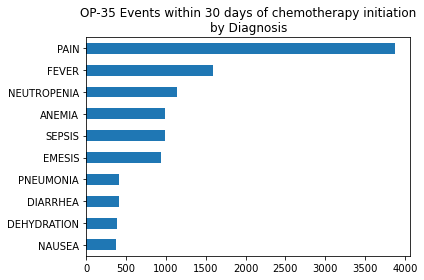

In [68]:
fig,ax = plt.subplots()
(cohort_p1_sym.DX_SHORT.value_counts()[::-1]).plot(kind="barh",title="OP-35 Events within 30 days of chemotherapy initiation\nby Diagnosis",ax=ax)
plt.tight_layout()

In [69]:
cohort_p1_sym.DX_SHORT.value_counts()

PAIN           3873
FEVER          1597
NEUTROPENIA    1144
ANEMIA          992
SEPSIS          989
EMESIS          933
PNEUMONIA       413
DIARRHEA        412
DEHYDRATION     387
NAUSEA          375
Name: DX_SHORT, dtype: int64

In [70]:
cohort_p1_sym.dropna(subset=['DX_SHORT'], inplace=True)

In [71]:
print("No of unique patients with at least one symptom: ", len(pd.unique(cohort_p1_sym['PAT_DEID'])))

No of unique patients with at least one symptom:  1817


In [72]:
# Save cohort patient with at least one symptom in predefined symptom classes -> save all the information
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.cohort_p1_sym_op30"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = cohort_p1_sym,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=6e38b714-729f-40af-aec3-50251f04ecac>

- Create cohort patient with at least one symptom in predefined symptom classes

In [73]:
cohort_p1_symptom = pd.merge(cohort_p1_sym.drop_duplicates(['PAT_DEID'])[['PAT_DEID']], cohort_p1_acu, how = 'left', on = ['PAT_DEID'])

In [74]:
cohort_p1_symptom

,PAT_DEID,HOSP_ADMSN_TIME,CHE_TX_DATE
0,1770802,2020-02-07 20:54:00,2020-01-16 00:00:00
1,3945576,2020-02-01 09:14:00,2020-01-24 00:00:00
2,1045640,2016-02-15 20:12:00,2016-02-08 00:00:00
3,1289918,2016-04-15 23:13:00,2016-03-16 00:00:00
4,2440956,2016-04-14 16:51:00,2016-03-24 00:00:00
...,...,...,...
1812,538184,2015-02-13 13:13:00,2015-01-16 08:59:00
1813,1253627,2019-03-14 16:38:00,2019-03-08 23:59:00
1814,3456627,2018-11-12 13:20:00,2018-10-17 09:59:00
1815,3316652,2014-06-06 19:31:00,2014-06-05 23:59:00


In [75]:
# Save cohort patient with at least one symptom in predefined symptom classes
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.cohort_p1_symptom"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = cohort_p1_symptom,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=66534523-ac32-4a1b-b0e4-dae685282f55>

### Select patients with at least one text in the observation period           

- Observation period: [CHE_TX_DATE,HOSP_ADMSN_TIME]

#### Build Text Table 


In [76]:
         sql_query = f""" SELECT * FROM {es}.cohort_p1_symptom"""
cohort_p1_symptom = (client.query(sql_query)).to_dataframe()

**-Build Note Table**

Note: The encounter date corresponds to the admission date for hospitalization and thus will collect all the notes relevant to this ACU event and thus all the ones written during the hospitalization period (even if hosp last a very long time)

The effective time seems to be when the notes was written/uploaded to the DB so might have an encounter date outside our observation period and this is not what we want

In [77]:
# Obtain the patients' notes in the observation period i.e created_time in [che_tx_date, HOSP_ADMSN_TIME] 
db = "som-nero-phi-boussard.stride_cancer_notes_msgs" # Define the database
db_elia = "som-nero-phi-boussard.ES_ACU_Oncology" # Define the database
sql_query = f"""
    SELECT DISTINCT cohort.pat_deid, notes.note, notes.encounter_date, notes.effective_time, notes.note_desc
    FROM {db_elia}.cohort_p1_symptom cohort
    INNER JOIN {db}.shc_cancer_notes notes ON cohort.pat_deid = notes.pat_deid
    WHERE (notes.encounter_date <= cohort.hosp_admsn_time 
    AND notes.encounter_date >= cohort.che_tx_date)
"""
df_notes = (client.query(sql_query)).to_dataframe()
df_notes.columns = [c.upper() for c in df_notes.columns]

In [78]:
print("No of unique patients with at least one note in the observation period: ", len(pd.unique(df_notes['PAT_DEID'])))

No of unique patients with at least one note in the observation period:  1753


In [79]:
# Check for null values
df_notes.isna().sum()

PAT_DEID          0
NOTE              0
ENCOUNTER_DATE    0
EFFECTIVE_TIME    0
NOTE_DESC         0
dtype: int64

In [80]:
# Check for duplicates notes for each patient
df_notes.duplicated(subset=['PAT_DEID', 'NOTE']).sum()

4377

In [81]:
df_notes.drop_duplicates(subset=['PAT_DEID', 'NOTE'], inplace=True)
df_notes.shape

(95536, 5)

In [82]:
# Add WORD_COUNT column (approximatif since account for long white spaces in the notes) 
df_notes["WORD_COUNT"] = df_notes["NOTE"].str.split(' ').str.len()

In [83]:
df_notes

,PAT_DEID,NOTE,ENCOUNTER_DATE,EFFECTIVE_TIME,NOTE_DESC,WORD_COUNT
0,1863459,Principal Investigator: Dr.Elisabeth Diver Nu...,2019-05-14,2019-05-14 11:49:00,Progress Notes,104
1,793691,Urologic Oncology Clinic 875 Blake Wilbur Dr...,2013-02-28,2013-02-28 00:00:00,Letter,472
2,3454010,"Hand-off given to RN, Jennifer from F wing. Pa...",2015-05-10,2015-05-10 19:48:00,ED Notes,19
3,1078094,Pt and pt's wife upset about waiting time for ...,2019-09-02,2019-09-02 18:29:00,ED Notes,26
4,154216,"OT Eval: Independent bed mob, STS, mobility wi...",2020-11-08,2020-11-09 09:50:00,Care Plan Note,35
...,...,...,...,...,...,...
99907,3594682,Stanf...,2019-09-20,2019-09-27 17:03:00,Progress Notes,620
99908,87359,I was asked to place Cortrak feeding tube for ...,2015-01-28,2015-02-11 23:55:00,Progress Notes,90
99909,2830373,"Problem: CONSTIPATION - RISK OF, DUE TO CHEMOT...",2013-11-06,2013-11-06 19:44:00,Progress Notes,45
99910,815873,Stanford Hospital and Clinics Discharge Summa...,2013-05-31,2013-06-05 08:08:00,Discharge Summary,1076


In [84]:
# Save cohort patient with at least one symptom in predefined symptom classes
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.note_table"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = df_notes,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=ae85cd46-ed1d-48a3-b342-198cda44d044>

#### Get the target cohort patient (with at least one text)

In [85]:
# Load relevant note table
sql_query = f""" SELECT * FROM {es}.note_table"""
note_table = (client.query(sql_query)).to_dataframe()

In [86]:
# Select patients that have at least one note or one message in the observation period 
#cohort_p1_text = pd.merge(message_table['PAT_DEID'], note_table['PAT_DEID'], how = 'outer', on = ['PAT_DEID'])
cohort_p1_text = note_table[['PAT_DEID']]

In [87]:
print("No of unique patients with at least one relevant note in the observation period: ", len(pd.unique(cohort_p1_text['PAT_DEID'])))

No of unique patients with at least one relevant note in the observation period:  1753


In [88]:
cohort_p1_text = pd.merge(cohort_p1_text.drop_duplicates(subset="PAT_DEID"), cohort_p1_symptom, how = 'left', on = ['PAT_DEID'])

In [89]:
# Save cohort patient with at least one symptom in predefined symptom classes
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.cohort_p1_text"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = cohort_p1_text,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=832c7228-e571-4d0e-89b3-3ca3cbe932ca>

- Save the cohort patient information table 

In [90]:
sql_query = f""" SELECT * FROM {es}.cohort_p1_sym_op30"""
cohort_p1_sym_op30 = (client.query(sql_query)).to_dataframe()

In [91]:
cohort_p1_sym_op30 = pd.merge(cohort_p1_text[["PAT_DEID"]], cohort_p1_sym_op30, how = 'left', on = ['PAT_DEID'])

In [92]:
print("No of unique patients: ", len(pd.unique(cohort_p1_sym_op30['PAT_DEID'])))

No of unique patients:  1753


In [93]:
# Save cohort patient with at least one symptom in predefined symptom classes
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.cohort_p1_sym_op30"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = cohort_p1_sym_op30,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=4f312659-572c-48fb-891a-81c4452818fa>